In [531]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime

import QuantLib as ql
from scipy.optimize import minimize

current_time = pd.Timestamp(year=2021, month=8, day=3, hour=12)
current_price = 4300.

df = pd.read_csv(r'spx_SABR.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')

# Remove IV=0 strikes from Dataframe
fltr = df[df["IV"] <= 0.]["Strike"].unique()
df = df[~df['Strike'].isin(fltr)]
df = df[~(df['Strike'] <= 3000)]

maturities = df['Date'].unique()
strikes = df["Strike"].unique()

today = ql.Date(3, 8, 2021)
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()
dates = [date_pd_to_ql(d) for d in maturities]

spot_quote = ql.QuoteHandle(ql.SimpleQuote(current_price))

rate = -.3
riskFreeCurve = ql.FlatForward(today, rate, ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)


POW = 10**-2
vols = [np.array(df[df["Date"] == maturities[m]]["IV"]* POW) for m in range(len(maturities))]

def delta_t(m):

    dt = m - today

    return round(dt/365, 6)

def date_pd_to_ql(date):
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    return ql.Date(day, month, year)

In [598]:
#PLOTTING

#Plot volatility Surface
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, .657, 0.1), plot_strikes=strikes, funct='blackVol'):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure(figsize=(20, 8))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.3)

def plot_smile(date, smiles):

    market_vols = vols[dates.index(date)]

    fig, ax = plt.subplots(figsize=(25, 5))
    for smile in smiles:
        ax.plot(strikes, smile[0], label=smile[1])
    ax.plot(strikes, market_vols, "x", label="Actual")
    ax.plot([4375], market_vols[41], "o", label="ATM")
    ax.set_xlabel("Strikes", size=12)
    ax.set_ylabel("Vols", size=12)
    legend = ax.legend(loc="upper right")


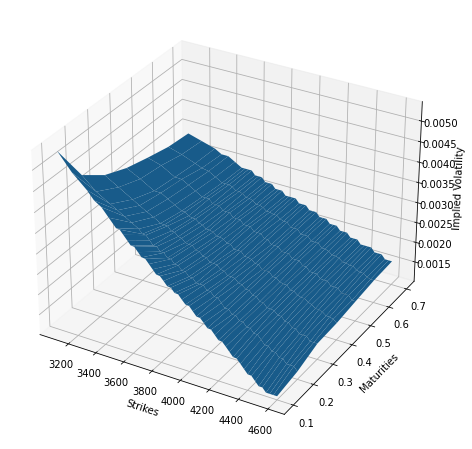

In [533]:
# BLACK VOLATILITY SURFACE

volMatrix = ql.Matrix(len(vols[0]), len(vols))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

black_var_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface.enableExtrapolation()

plot_vol_surface(vol_surface=black_var_surface , plot_years=np.arange(0.1, .8, 0.1), plot_strikes=strikes, funct='blackVol')

In [534]:
#CALIBRATE VOLATILITY SURFACE

def volatilitySmileSABR(date, shift=0, beta=1, method="normal"):

    fwd = current_price
    expiryTime = delta_t(date)
    marketVols = vols[dates.index(date)]

    def set_beta():
        return beta

    def vols_by_method(strike, fwd, expiryTime, alpha, beta, nu, rho, shift):
        if method == "floch-kennedy":
            return ql.sabrFlochKennedyVolatility(strike + shift, fwd + shift, expiryTime, alpha, beta, nu, rho)
        else:
            return ql.sabrVolatility(strike + shift, fwd + shift, expiryTime, alpha, beta, nu, rho)

    def f(params):

        alpha, beta, nu, rho = params

        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        beta = set_beta()
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) # Avoid rhp going < -1.0
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([
        vols_by_method(strike, fwd, expiryTime, alpha, beta, nu, rho, shift)
        for strike in strikes
        ])

        error = ((vols - np.array(marketVols))**2 ).mean() **.5

        return error

    cons = (
    {'type': 'ineq', 'fun': lambda x: x[0]},
    # {'type': 'ineq', 'fun': lambda x: 0.99 - x[1]},
    # {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: .99 - x[3]**2}
    )

    x = [.1, set_beta(), .01, .1]

    result = minimize(f, x, constraints=cons, method="SLSQP")
    error = result['fun']
    [alpha, beta, nu, rho] = result['x']

    newVols = [vols_by_method(strike, fwd, expiryTime, alpha, beta, nu, rho, shift) for strike in strikes]
    
    return dict(vols=newVols, error=error, params={"alpha": alpha, "beta": beta, "nu": nu, "rho": rho})

def volatilitySurfaceSABR(method="normal", beta=1, shift=0):

    vol_surface_vector, errors, _alpha, _beta, _nu, _rho = [], [], [], [], [], []
    SABRVolMatrix = ql.Matrix(len(strikes), len(dates))
    
    for i, d in enumerate(dates):
        volSABR = volatilitySmileSABR(date=d, beta=beta, shift=shift, method=method)

        _alpha.append(volSABR["params"]["alpha"])
        _beta.append(volSABR["params"]["beta"])
        _nu.append(volSABR["params"]["nu"])
        _rho.append(volSABR["params"]["rho"])
        
        errors.append(volSABR["error"])

        smile = volSABR["vols"]
        vol_surface_vector.extend(smile)

        #constructing the SABRVolatilityMatrix
        for j in range(len(smile)):
            SABRVolMatrix[j][i] = smile[j]
            
    return dict(vols=vol_surface_vector, volMatrix=SABRVolMatrix, e=errors, a=_alpha, b=_beta, n=_nu, r=_rho)


,alpha,beta,nu,rho
2021-08-06,0.000151,1.0,0.552560,0.093509
2021-08-09,0.000123,1.0,0.275207,0.097364
2021-08-11,0.000120,1.0,0.244438,0.097466
2021-08-13,0.000117,1.0,0.213653,0.098098
2021-08-16,0.000114,1.0,0.190692,0.098381
2021-08-20,0.000114,1.0,0.190684,0.098380
2021-08-23,0.000111,1.0,0.155161,0.099071
2021-08-25,0.000111,1.0,0.151641,0.099120
2021-08-27,0.000110,1.0,0.150200,0.099145
2021-09-10,0.000108,1.0,0.128747,0.099450


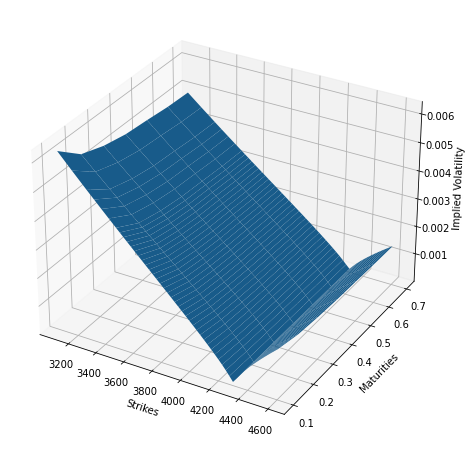

In [535]:
#SABR VOLATILITY SURFACE

volatility_surface = volatilitySurfaceSABR(method="normal", shift=0, beta=1)
SABRVolMatrix = volatility_surface["volMatrix"]

SABR_vol_surface  = ql.BlackVarianceSurface(today, calendar, dates, strikes, SABRVolMatrix, day_count)
SABR_vol_surface.enableExtrapolation()

plot_vol_surface(vol_surface=SABR_vol_surface , plot_years=np.arange(0.1, .8, 0.1), plot_strikes=strikes, funct='blackVol')

d = {'alpha': volatility_surface["a"], 'beta': volatility_surface["b"], 'nu': volatility_surface["n"], 'rho': volatility_surface["r"]}
pd.DataFrame(data=d, index=maturities)

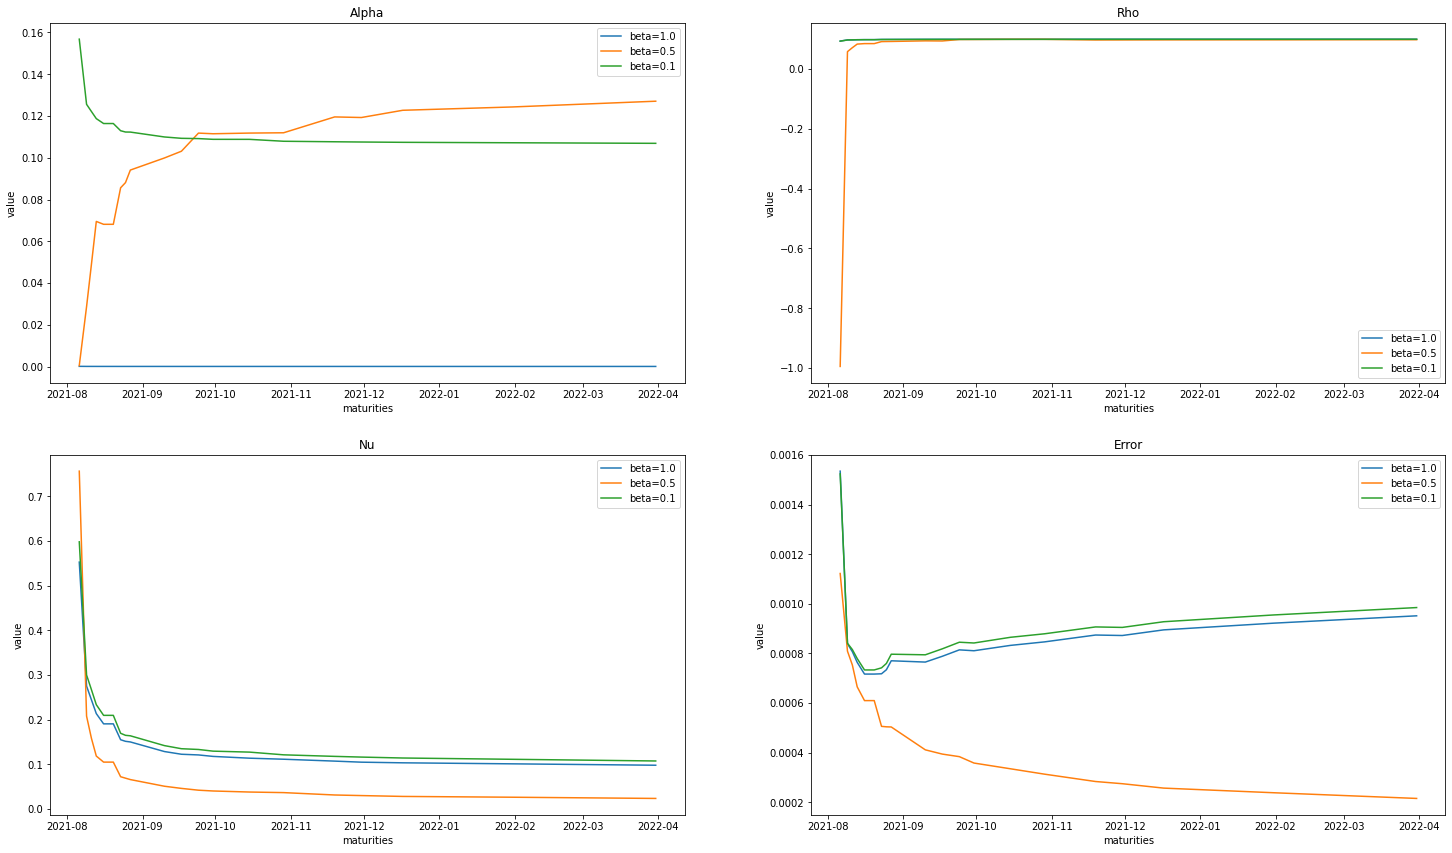

In [536]:
# Normal SABR Volatility model

method1 = volatilitySurfaceSABR(beta=1, shift=0)
method2 = volatilitySurfaceSABR(beta=.5, shift=0)
method3 = volatilitySurfaceSABR(beta=.1, shift=0)

fig, axs = plt.subplots(2, 2, figsize=(25,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
for method in [method1, method2, method3]:
    axs[0, 0].plot(maturities, method["a"], label="beta={}".format(method["b"][1]))
    axs[0, 0].set_title('Alpha')
    axs[0, 0].set(xlabel='maturities', ylabel='value')
    axs[0, 0].legend()
    axs[1, 0].plot(maturities, method["n"], label="beta={}".format(method["b"][1]))
    axs[1, 0].set_title('Nu')
    axs[1, 0].set(xlabel='maturities', ylabel='value')
    axs[1, 0].legend()
    axs[0, 1].plot(maturities, method["r"], label="beta={}".format(method["b"][1]))
    axs[0, 1].set_title('Rho')
    axs[0, 1].set(xlabel='maturities', ylabel='value')
    axs[0, 1].legend()
    axs[1, 1].plot(maturities, method["e"], label="beta={}".format(method["b"][1]))
    axs[1, 1].set_title('Error')
    axs[1, 1].set(xlabel='maturities', ylabel='value')
    axs[1, 1].legend()

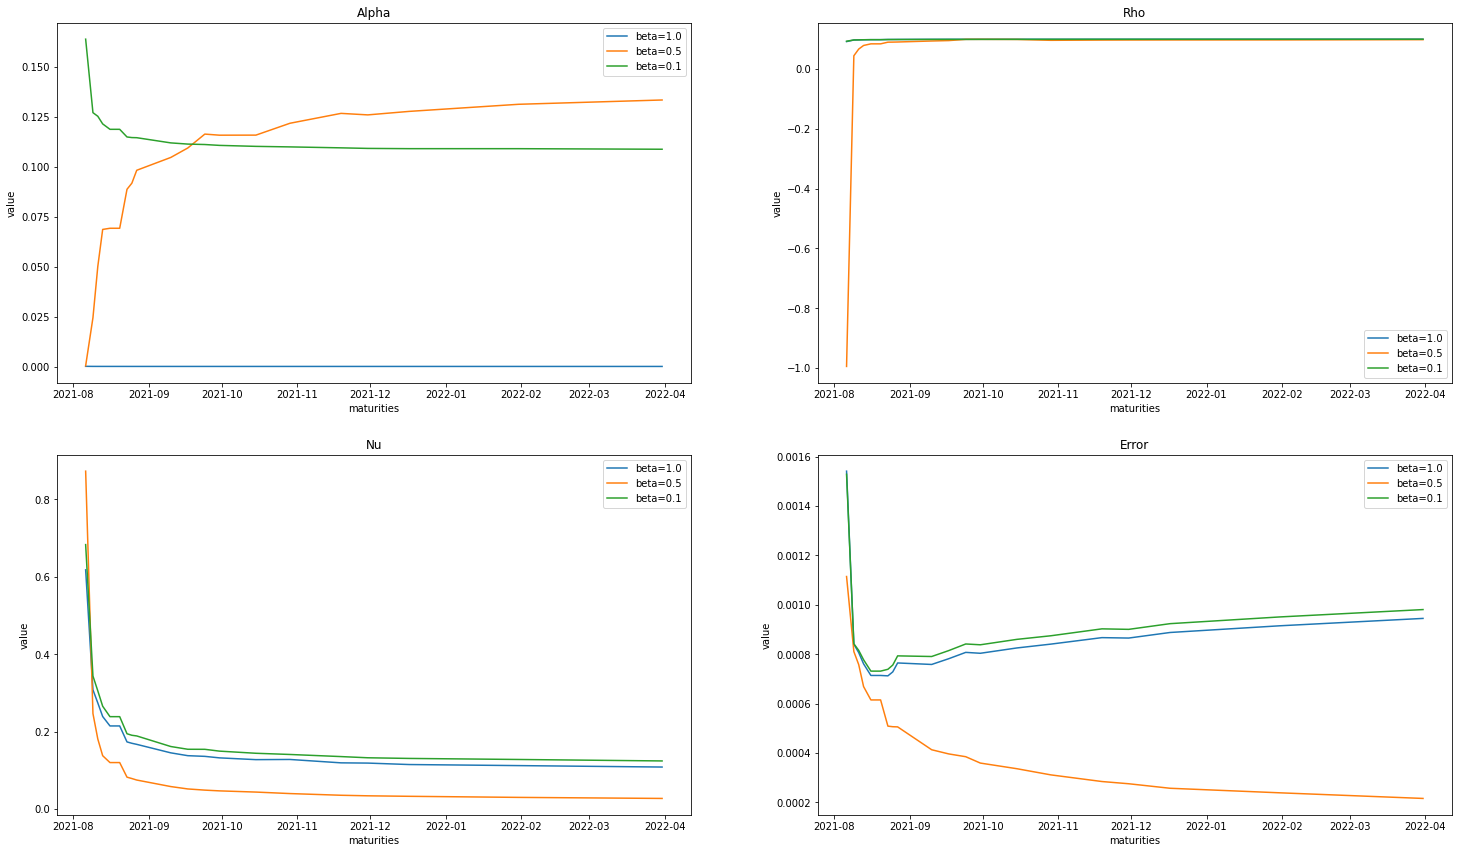

In [537]:
# Shifted SABR Volatility model

method1 = volatilitySurfaceSABR(beta=1, shift=500)
method2 = volatilitySurfaceSABR(beta=.5, shift=500)
method3 = volatilitySurfaceSABR(beta=.1, shift=500)

fig, axs = plt.subplots(2, 2, figsize=(25,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
for method in [method1, method2, method3]:
    axs[0, 0].plot(maturities, method["a"], label="beta={}".format(method["b"][1]))
    axs[0, 0].set_title('Alpha')
    axs[0, 0].set(xlabel='maturities', ylabel='value')
    axs[0, 0].legend()
    axs[1, 0].plot(maturities, method["n"], label="beta={}".format(method["b"][1]))
    axs[1, 0].set_title('Nu')
    axs[1, 0].set(xlabel='maturities', ylabel='value')
    axs[1, 0].legend()
    axs[0, 1].plot(maturities, method["r"], label="beta={}".format(method["b"][1]))
    axs[0, 1].set_title('Rho')
    axs[0, 1].set(xlabel='maturities', ylabel='value')
    axs[0, 1].legend()
    axs[1, 1].plot(maturities, method["e"], label="beta={}".format(method["b"][1]))
    axs[1, 1].set_title('Error')
    axs[1, 1].set(xlabel='maturities', ylabel='value')
    axs[1, 1].legend()

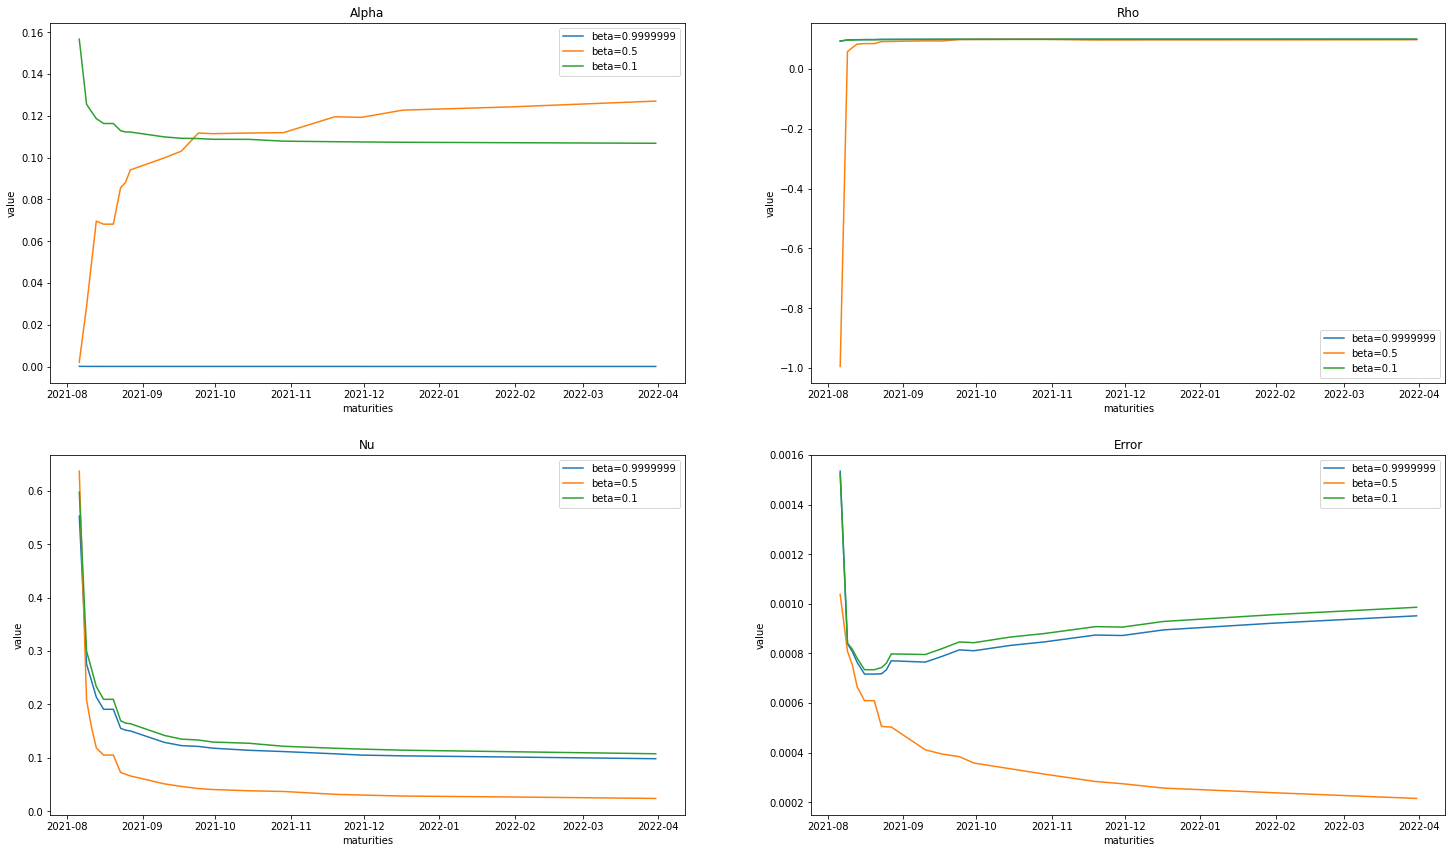

In [538]:
# Floch-Kennedy SABR Volatility model

method1 = volatilitySurfaceSABR(beta=.9999999, shift=0, method="floch-kennedy")
method2 = volatilitySurfaceSABR(beta=.5, shift=0, method="floch-kennedy")
method3 = volatilitySurfaceSABR(beta=.1, shift=0, method="floch-kennedy")

fig, axs = plt.subplots(2, 2, figsize=(25,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
for method in [method1, method2, method3]:
    axs[0, 0].plot(maturities, method["a"], label="beta={}".format(method["b"][1]))
    axs[0, 0].set_title('Alpha')
    axs[0, 0].set(xlabel='maturities', ylabel='value')
    axs[0, 0].legend()
    axs[1, 0].plot(maturities, method["n"], label="beta={}".format(method["b"][1]))
    axs[1, 0].set_title('Nu')
    axs[1, 0].set(xlabel='maturities', ylabel='value')
    axs[1, 0].legend()
    axs[0, 1].plot(maturities, method["r"], label="beta={}".format(method["b"][1]))
    axs[0, 1].set_title('Rho')
    axs[0, 1].set(xlabel='maturities', ylabel='value')
    axs[0, 1].legend()
    axs[1, 1].plot(maturities, method["e"], label="beta={}".format(method["b"][1]))
    axs[1, 1].set_title('Error')
    axs[1, 1].set(xlabel='maturities', ylabel='value')
    axs[1, 1].legend()

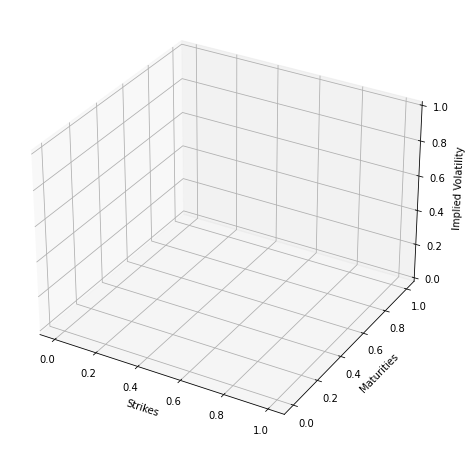

In [539]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

black_var_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
#if does not work use NoExceptLocalVolSurface
local_vol_surface = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, .25)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, plot_years=np.arange(0.1, .657, 0.1), plot_strikes=strikes[60:], funct='localVol')


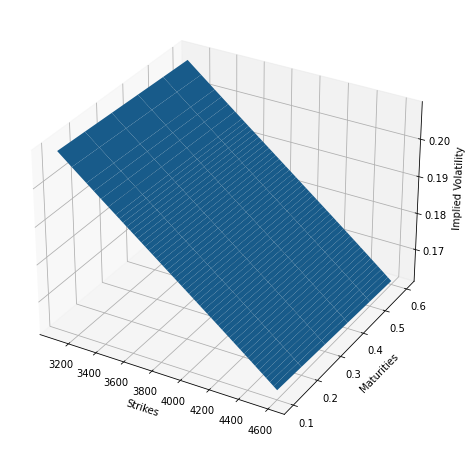

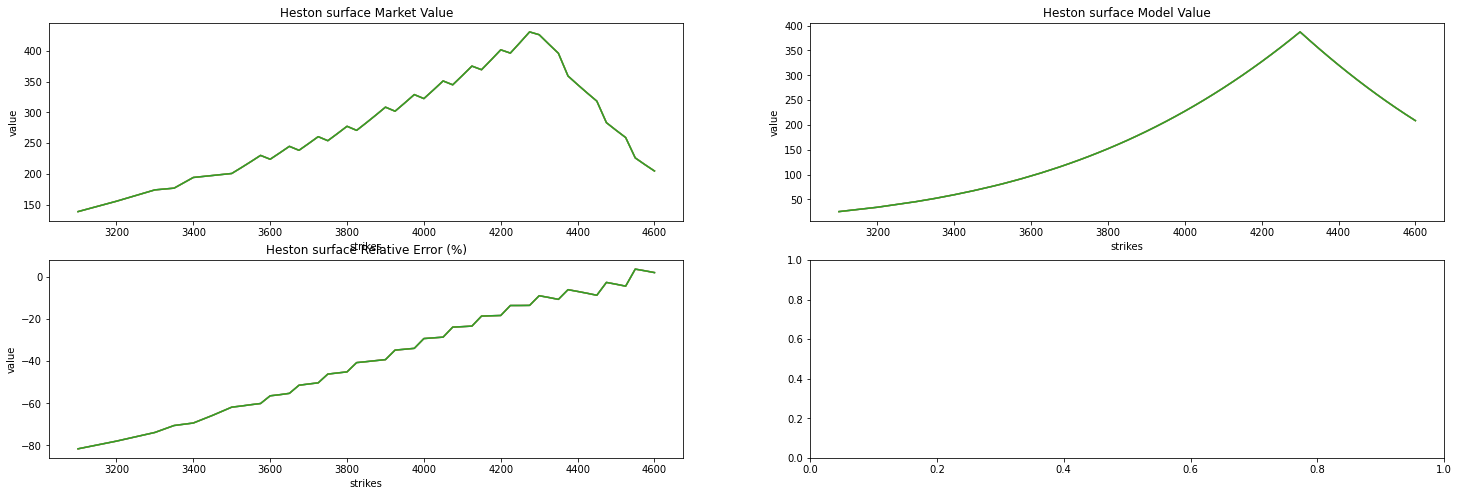

In [587]:
#HESTON MODEL SURFACE PLOTTING (Levenberg-Marquardt Method)

# dummy parameters
v0, kappa, theta, rho, sigma = (0.03, 0.01, 0.08, -0.9, .1)

process = ql.HestonProcess(flat_ts, dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(spot)), 
                           v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model) 

heston_helpers = []
black_var_surface.setInterpolation("bicubic")
one_year_idx = 19 
date = dates[one_year_idx]

for j, s in enumerate(strikes):
    t = (date - today)
    p = ql.Period(t, ql.Days)
    sigma = vols[one_year_idx][j] / POW

    helper = ql.HestonModelHelper(p, calendar, spot, s, 
                                  ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                  flat_ts, 
                                  dividend_ts)
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm, 
                 ql.EndCriteria(5000, 500, 1.0e-8, 1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()

# Boilerplate to get to the Vol Surface object
heston_model = ql.HestonModel(process)
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Plot the vol surface ...
plot_vol_surface(heston_vol_surface)


# Statistical analysis on the Heston model and plotting

strks, marketValue, modelValue, relativeError = ([], [], [], [])

avgError = 0
for i, opt in enumerate(heston_helpers):
    err = (opt.modelValue()/opt.marketValue() - 1.0)
    strks.append(strikes[i]); marketValue.append(opt.marketValue()); modelValue.append(opt.modelValue()); relativeError.append(100.0*(opt.modelValue()/opt.marketValue() - 1.0))
    avgError += abs(err)
avgError = avgError*100.0/len(heston_helpers)

market_errors = pd.DataFrame({"Strikes": strks, "Market Value": marketValue, "Model Value": modelValue, "Relative Error (%)": relativeError})

fig, axs = plt.subplots(2, 2, figsize=(25,8))
for column in market_errors.columns.tolist()[1:]:
    axs[0, 0].plot(strks, marketValue)
    axs[0, 0].set_title('Heston surface Market Value')
    axs[0, 0].set(xlabel='strikes', ylabel='value')
    axs[0, 1].plot(strks, modelValue)
    axs[0, 1].set_title('Heston surface Model Value')
    axs[0, 1].set(xlabel='strikes', ylabel='value')
    axs[1, 0].plot(strks, relativeError)
    axs[1, 0].set_title('Heston surface Relative Error (%)')
    axs[1, 0].set(xlabel='strikes', ylabel='value')


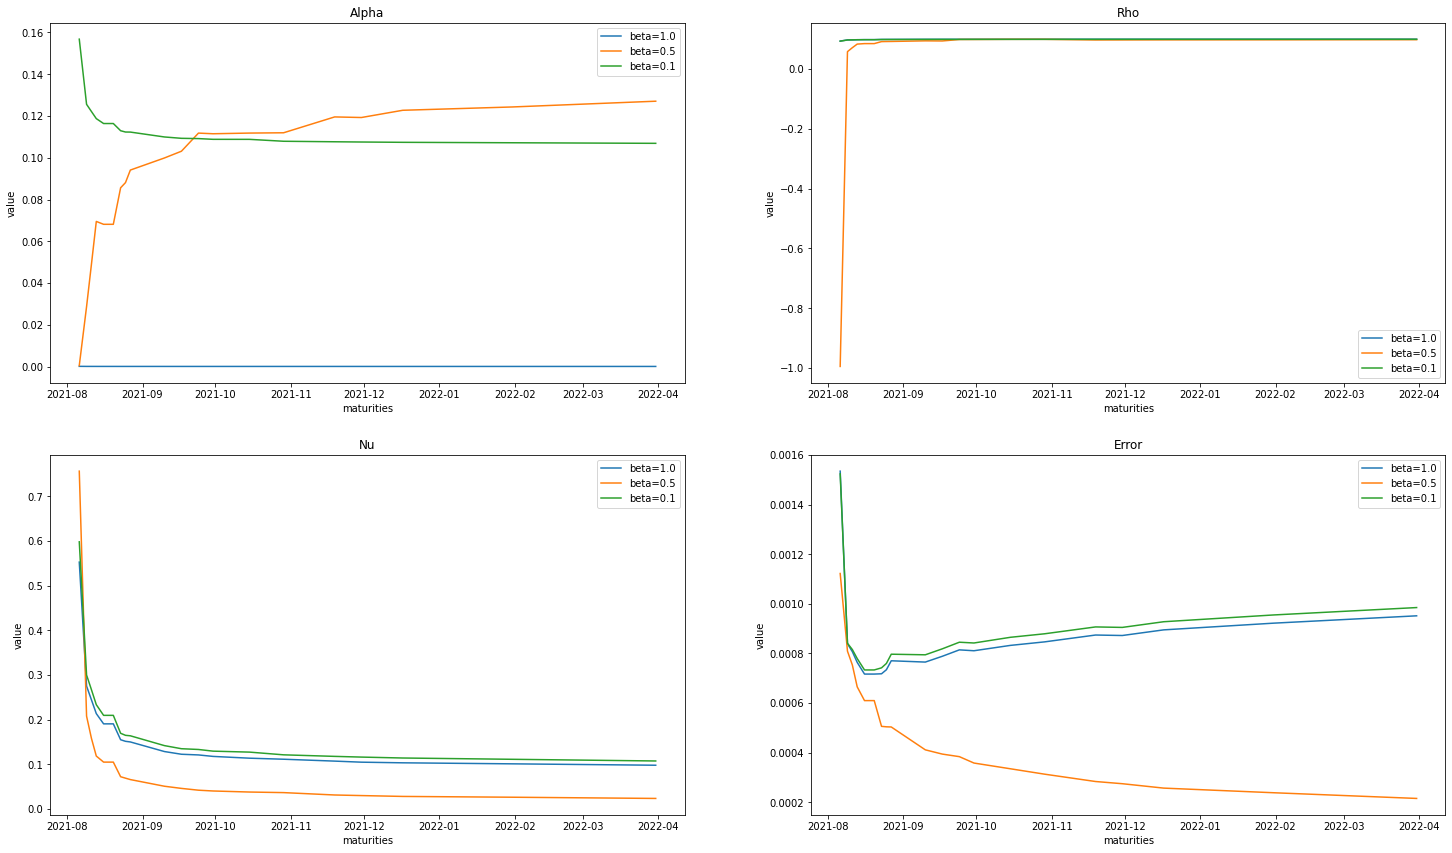

In [536]:
# Normal SABR Volatility model

method1 = volatilitySurfaceSABR(beta=1, shift=0)
method2 = volatilitySurfaceSABR(beta=.5, shift=0)
method3 = volatilitySurfaceSABR(beta=.1, shift=0)

fig, axs = plt.subplots(2, 2, figsize=(25,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
for method in [method1, method2, method3]:
    axs[0, 0].plot(maturities, method["a"], label="beta={}".format(method["b"][1]))
    axs[0, 0].set_title('Alpha')
    axs[0, 0].set(xlabel='maturities', ylabel='value')
    axs[0, 0].legend()
    axs[1, 0].plot(maturities, method["n"], label="beta={}".format(method["b"][1]))
    axs[1, 0].set_title('Nu')
    axs[1, 0].set(xlabel='maturities', ylabel='value')
    axs[1, 0].legend()
    axs[0, 1].plot(maturities, method["r"], label="beta={}".format(method["b"][1]))
    axs[0, 1].set_title('Rho')
    axs[0, 1].set(xlabel='maturities', ylabel='value')
    axs[0, 1].legend()
    axs[1, 1].plot(maturities, method["e"], label="beta={}".format(method["b"][1]))
    axs[1, 1].set_title('Error')
    axs[1, 1].set(xlabel='maturities', ylabel='value')
    axs[1, 1].legend()

In [584]:
heston_vol_surface.blackVol(dates[0], strikes[0])

0.5022146145388577

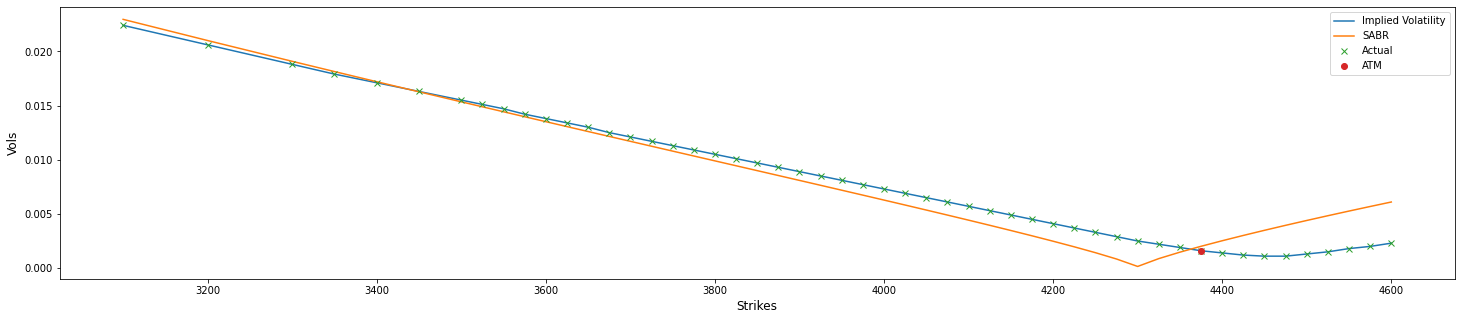

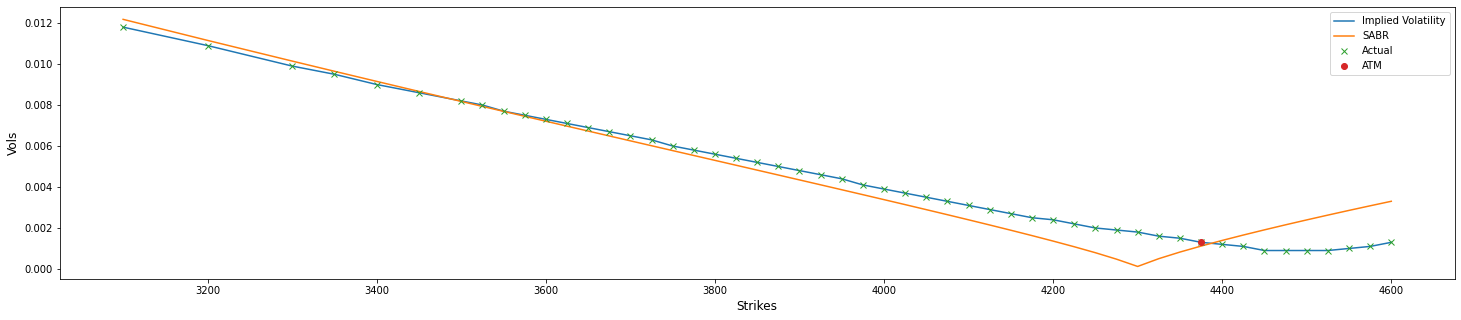

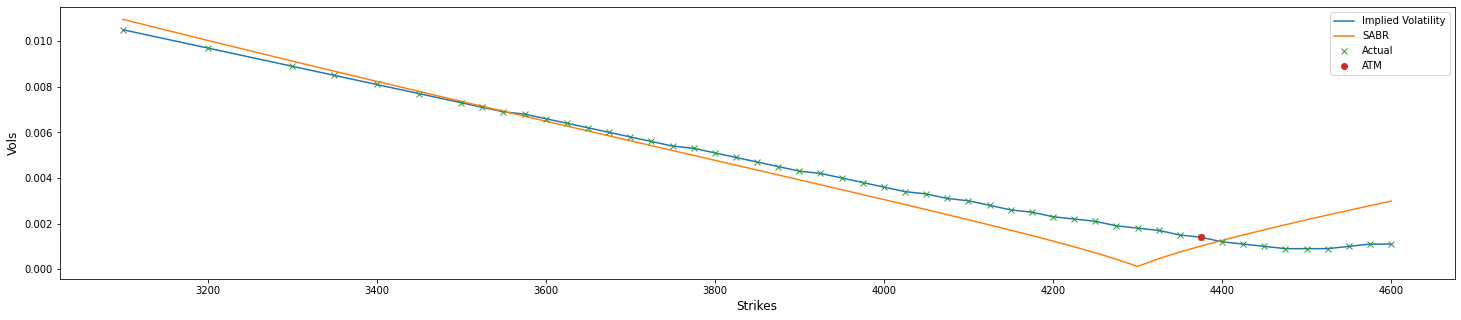

In [600]:
for i in range(3):
        num = i
        lis = [([black_var_surface.blackVol(dates[num], s) for s in strikes], "Implied Volatility" ),
                # ([heston_vol_surface.blackVol(dates[num], s)/POW for s in strikes], "Heston" ),
                ([SABR_vol_surface.blackVol(dates[num], s) for s in strikes], "SABR" )
                ]
        plot_smile(dates[num], lis)

C:\Users\somig\AppData\Local\Temp/ipykernel_12792/4135359516.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


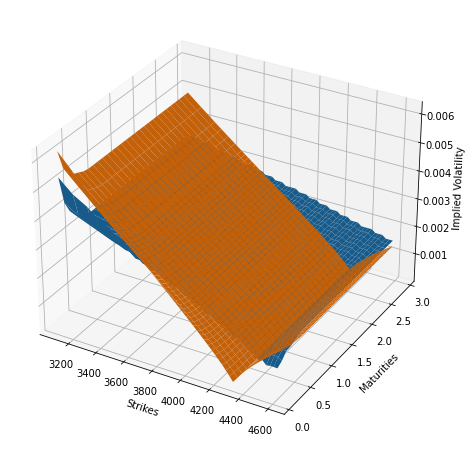

In [ ]:
plot_vol_surface([black_var_surface, SABR_vol_surface])